# Preperation

## Import Libraries and Data

In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, classification_report, plot_confusion_matrix, \
accuracy_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [17]:
wells4 = pd.read_csv('data/wells4.csv', index_col = 0)

## Feature Engineering

#### Create well_age feature

In [18]:
wells4['well_age'] = wells4.year_recorded - wells4.construction_year

In [19]:
print(wells4.well_age.describe())
print(wells4.well_age.loc[lambda x : x<0])

count    59400.000000
mean        15.042374
std         10.100175
min         -7.000000
25%          8.000000
50%         14.000000
75%         16.000000
max         53.000000
Name: well_age, dtype: float64
8729    -4
10441   -2
13366   -7
23373   -5
27501   -5
32619   -1
33942   -3
39559   -5
48555   -4
Name: well_age, dtype: int64


Obviously it is not possible to have a well with a negative age.  Likely erroneous values in the original dataset for construction_year or date_recorded.  Since they are few in number, I will set the negative values to null and use a SimpleImputer in the Column Transformer.

In [20]:
wells4.loc[wells4.well_age < 0, "well_age"] = np.nan

#### Convert Appropriate Numeric Columns to Categorical

In [21]:
wells4[['construction_year', 'year_recorded']] = wells4[['construction_year', 'year_recorded']].astype('str')

### Create Train Test Split

In [22]:
X = wells4.drop(['status_group'], axis=1)
y = wells4['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=52)

### Subpipes & Column Transformer

In [23]:
# Create pipelines to properly scale / encode different data types for use in column transformer

subpipe_num = Pipeline(steps=[
    ('num_impute', SimpleImputer()),
    ('ss', StandardScaler())
    ])

subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

#subpipe_ord = Pipeline(steps=[('ord', OrdinalEncoder())])

In [24]:
# Create list of features for each subpipe
cat_feat = X_train.select_dtypes(include=['object']).columns
num_feat = X_train.select_dtypes(include=['float', 'int64']).columns


In [25]:
ct = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, num_feat),
    ('subpipe_cat', subpipe_cat, cat_feat),
    #('subpipe_ord', subpipe_ord, ord_feat)
    ])

# Modeling
Since water is so vital, the Tanzanian government does not want to miss any wells that need work.  The modeling process will aim to minimize the number of wells that are predicted to be functional, but actually need work (false negatives).  Therefore recall will be used as the primary scoring metric with secondary consideration for accuracy, because it would be wasteful to send engineers to every water point.  

### Dummy Classifier

In [133]:
# Using a pipeline to maintain consistency with later models, dummy strategy of most frequent to establlish a baseline

dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dum', DummyClassifier(strategy='stratified', random_state=52))
])

In [134]:
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [135]:
recall_score(y_train, dummy_pipe.predict(X_train))

0.45710633695491865

In [136]:
accuracy_score(y_train, dummy_pipe.predict(X_train))

0.5046464646464647

With a recall score of 45.7% and an accuracy of 50.4% the dummy model is effectively useless, which provides plenty of room for improvement.

### First Simple Model

In [38]:
dct_pipe = Pipeline(steps=[
    ('ct',ct),
    ('dct', DecisionTreeClassifier(random_state=52))
])

In [39]:
dct_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [41]:
recall_score(y_train, dct_pipe.predict(X_train))

0.9924782459072808

In [42]:
accuracy_score(y_train, dct_pipe.predict(X_train))

0.9948148148148148

In [43]:
cross_val_score(dct_pipe, X_train, y_train, scoring='recall', error_score='raise')

array([0.75817154, 0.74508358, 0.74459194, 0.75589971, 0.75958702])

In [44]:
cross_val_score(dct_pipe, X_train, y_train, scoring='accuracy', error_score='raise')

array([0.77654321, 0.771156  , 0.7704826 , 0.77160494, 0.77272727])

#### Evaluation
The untuned decision tree model performs ~30% wetter at recall than the baseline and ~25% better accuracy.  It is also significantly overfit. FSM was useful in identifying that some categoricals were causing it to run very slowly. Eliminated some features with further EDA and reran FSM.

### Second Model

In [45]:
lr_pipe = Pipeline(steps=[
    ('ct',ct),
    ('lr', LogisticRegression(random_state=52, max_iter=750))
    ])

In [46]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [47]:
# defaults and max iter=750
cross_val_score(lr_pipe, X_train, y_train, scoring='recall', error_score='raise')

array([0.61587614, 0.59857424, 0.60447394, 0.61307768, 0.61455261])

In [48]:
cross_val_score(lr_pipe, X_train, y_train, scoring='accuracy', error_score='raise')

array([0.73939394, 0.73378227, 0.74029181, 0.74500561, 0.74466891])

#### GridSearch 
Untuned LogReg underperformed it's DCT counterpart, trying Gridsearch to tune LogReg hyperparameters

In [49]:
params = {}
params['lr__solver'] = ['newton-cg', 'lbfgs', 'saga']
params['lr__C'] = [.25, .5, 1, 2]

In [50]:
gs = GridSearchCV(estimator=lr_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')

In [51]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [52]:
gs.cv_results_['mean_test_score']

array([0.60773775, 0.60773775, 0.60783607, 0.60842601, 0.60847518,
       0.60832771, 0.60936007, 0.60931092, 0.60921259, 0.60955675,
       0.60940926, 0.60931093])

In [53]:
gs.best_params_

{'lr__C': 2, 'lr__solver': 'newton-cg'}

#### LR Follow Up GridsearchCV
Initial tuning had limited success.  Will try taking the best params and tweaking other hyperparameters

In [54]:
params = {}
params['lr__solver'] = ['newton-cg']
params['lr__C'] = [1, 2, 10]
params['lr__penalty'] = ['l2', 'none']

In [55]:
gs1 = GridSearchCV(estimator=lr_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')

In [57]:
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [58]:
gs1.cv_results_['mean_test_score']

array([0.60936007, 0.60995002, 0.60955675, 0.60995002, 0.61004835,
       0.60995002])

In [59]:
gs1.best_params_

{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}

#### Final attempt at tuning LR

In [60]:
params = {}
params['lr__solver'] = ['newton-cg', 'liblinear']
params['lr__C'] = [10, 50, 100]
params['lr__penalty'] = ['l2']

In [61]:
gs1_2 = GridSearchCV(estimator=lr_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')
gs1_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [62]:
gs1_2.best_params_

{'lr__C': 100, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

In [63]:
gs1_2.cv_results_['mean_test_score']

array([0.61004835, 0.61004835, 0.61004834, 0.60995001, 0.60999917,
       0.61009749])

#### No Improvement
With virtually no improvement after three rounds of parameter tuning, LogReg does not appear to be a good fit.

### Model 3 A Tuned DTC?

In [64]:
params = {}
params['dct__criterion'] = ['gini', 'entropy']
params['dct__max_depth'] = [5, 10, 25]

gs3 = GridSearchCV(estimator=dct_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')

In [65]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [66]:
gs3.cv_results_['mean_test_score']

array([0.52170401, 0.56309781, 0.73039624, 0.51192001, 0.54343244,
       0.72415255])

In [67]:
gs3.best_params_

{'dct__criterion': 'gini', 'dct__max_depth': 25}

#### Second tune
Scores were actually down slightly from the untuned DCT and the max_depth choose the highest value, so I will try rerunning with higher values for that param

In [68]:
params = {}
params['dct__criterion'] = ['gini', 'entropy']
params['dct__max_depth'] = [25, 52, 100]

gs3_2 = GridSearchCV(estimator=dct_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')

In [69]:
gs3_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [70]:
gs3_2.cv_results_['mean_test_score']

array([0.73039624, 0.75197846, 0.75266676, 0.72415255, 0.74976641,
       0.74937309])

In [71]:
gs3_2.best_params_

{'dct__criterion': 'gini', 'dct__max_depth': 100}

#### Third Tune
The best DTC params so far are gini and max_depth 100.  Will  try a higher max_depth and try other params

In [72]:
params = {}
params['dct__criterion'] = ['gini']
params['dct__max_depth'] = [100, 200, 500]
params['dct__min_samples_leaf'] = [1, 3, 5, 10]
print(params)

gs3_3 = GridSearchCV(estimator=dct_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')

{'dct__criterion': ['gini'], 'dct__max_depth': [100, 200, 500], 'dct__min_samples_leaf': [1, 3, 5, 10]}


In [73]:
gs3_3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [74]:
gs3_3.cv_results_['mean_test_score']

array([0.75266676, 0.74371955, 0.74003236, 0.72243182, 0.75266676,
       0.74371955, 0.74003236, 0.72243182, 0.75266676, 0.74371955,
       0.74003236, 0.72243182])

In [75]:
gs3_3.best_params_

{'dct__criterion': 'gini', 'dct__max_depth': 100, 'dct__min_samples_leaf': 1}

#### Evaluation
Unfortunately, tuning the DTC did not significantly improve the recall score. 

### Model 4: Trying Different estimators & the Stacking Ensemble 

In [76]:
stc = StackingClassifier(n_jobs=-3, estimators=[
    ('knn', KNeighborsClassifier()),
    ('rfc', RandomForestClassifier(random_state=52)),
    ('gbc', GradientBoostingClassifier(random_state=52))
    ])

In [77]:
stc_pipe = Pipeline([('ct',ct), ('stc', stc)])

In [78]:
stc_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [79]:
stc_pipe.score(X_train, y_train)

0.9723007856341189

In [80]:
recall_score(y_train, stc_pipe.predict(X_train))

0.9598839781721646

In [81]:
cross_val_score(stc_pipe, X_train, y_train, scoring='recall', error_score='raise')

array([0.75423937, 0.74778761, 0.74262537, 0.75245821, 0.75688299])

#### Evaluation
A modest improvement over the tuned DTC, however it is quite over fit.  Will try to reduce overfit with hyperparameter tuning.

In [82]:
params = {}
params['stc__knn__n_neighbors'] = [5,10, 50]
params['stc__rfc__criterion'] = ['gini','entropy']
params['stc__rfc__min_samples_leaf'] = [1,5,10]


In [83]:
gs4 = GridSearchCV(estimator=stc_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')

In [84]:
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [85]:
gs4.cv_results_['mean_test_score']

array([0.75079871, 0.73565694, 0.73192046, 0.74932392, 0.73644346,
       0.73339552, 0.75271597, 0.73329735, 0.72552976, 0.75129034,
       0.73383812, 0.72720118, 0.75458429, 0.73138008, 0.71830314,
       0.75281439, 0.73265825, 0.71820458])

Overall, a little bit worse than the untuned stc

In [86]:
gs4.best_params_

{'stc__knn__n_neighbors': 50,
 'stc__rfc__criterion': 'gini',
 'stc__rfc__min_samples_leaf': 1}

#### Second Tune Focused on n_neighbors

In [87]:
params = {}
params['stc__knn__n_neighbors'] = [50, 100, 1000]
params['stc__rfc__criterion'] = ['gini']

In [88]:
gs4_2 = GridSearchCV(estimator=stc_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')

In [89]:
gs4_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [90]:
gs4_2.cv_results_['mean_test_score']

array([0.75458429, 0.7534536 , 0.75129061])

In [91]:
gs4.best_params_

{'stc__knn__n_neighbors': 50,
 'stc__rfc__criterion': 'gini',
 'stc__rfc__min_samples_leaf': 1}

### Model 5: Reducing complexity by using only RFC

In [92]:
rfc_pipe = Pipeline(steps=[
    ('ct',ct),
    ('rfc', RandomForestClassifier(random_state=52))
    ])

In [93]:
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [94]:
cross_val_score(rfc_pipe, X_train, y_train, scoring='recall')

array([0.7559597 , 0.75516224, 0.75442478, 0.7605703 , 0.75860374])

#### RFC Tuning 1
Untuned RFC produced the best precision yet, but still very overfit.

In [95]:
params = {}

params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__max_depth'] = [25, 50, 100, 250]

In [96]:
gs5 = GridSearchCV(estimator=rfc_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')

In [97]:
gs5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [98]:
gs5.cv_results_['mean_test_score']

array([0.73373958, 0.75777996, 0.75694415, 0.75694415, 0.72700441,
       0.75895976, 0.75822226, 0.75822226])

In [99]:
gs5.best_params_

{'rfc__criterion': 'entropy', 'rfc__max_depth': 50}

#### Second Tune

In [100]:
params = {}

params['rfc__n_estimators'] = [100, 200, 500]
params['rfc__max_depth'] = [75, 100, 125]

In [101]:
gs5_2 = GridSearchCV(estimator=rfc_pipe, param_grid=params, cv=5, n_jobs=-2, scoring='recall')

In [102]:
gs5_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [103]:
gs5_2.cv_results_['mean_test_score']

array([0.75694415, 0.75915638, 0.76058205, 0.75694415, 0.75915638,
       0.76048372, 0.75694415, 0.75915638, 0.76048372])

In [104]:
gs5_2.best_params_

{'rfc__max_depth': 75, 'rfc__n_estimators': 500}

More Estimators -> Slightly less overfit

In [108]:
params = {}

params['rfc__n_estimators'] = [500, 1000]
params['rfc__max_depth'] = [75]
params['rfc__min_samples_split'] = [5, 10, 25]

In [109]:
gs5_3 = GridSearchCV(estimator=rfc_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')

In [110]:
gs5_3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [111]:
gs5_3.cv_results_['mean_test_score']

array([0.75576387, 0.75650136, 0.7471115 , 0.74725903, 0.72503802,
       0.72548052])

In [112]:
gs5_3.best_params_

{'rfc__max_depth': 75, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 1000}

#### Final Tune Attempt

In [121]:
params = {}

params['rfc__n_estimators'] = [1000, 2000]
params['rfc__max_depth'] = [75]
params['rfc__min_samples_split'] = [1, 3, 5]

In [122]:
gs5_4 = GridSearchCV(estimator=rfc_pipe, param_grid=params, cv=5, n_jobs=-3, scoring='recall')

In [123]:
gs5_4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                               

In [124]:
gs5_4.cv_results_['mean_test_score']

array([       nan,        nan, 0.76018871, 0.75905801, 0.75650136,
       0.75635392])

In [125]:
gs5_4.best_params_

{'rfc__max_depth': 75, 'rfc__min_samples_split': 3, 'rfc__n_estimators': 1000}

## Final Model

In [127]:
final_pipe = Pipeline(steps=[
    ('ct',ct),
    ('rfc', RandomForestClassifier(max_depth=75, min_samples_split=3, n_estimators=1000, random_state=52))
    ])

In [128]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'longitude', 'latitude', 'population', 'well_age'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['basin', 'region', 'construction_year', 'ex

In [129]:
cross_val_score(final_pipe, X_train, y_train, scoring='recall')

array([0.76161219, 0.76155359, 0.75393314, 0.76302852, 0.76081613])

In [132]:
print(f"""
    Final Test Accuracy: {accuracy_score(y_test, final_pipe.predict(X_test))}
    Final Test Recall: {recall_score(y_test, final_pipe.predict(X_test))}
""")


    Final Test Accuracy: 0.8121885521885522
    Final Test Recall: 0.7545588235294117



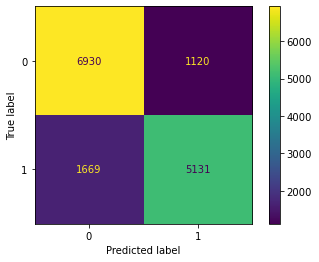

In [131]:
plot_confusion_matrix(final_pipe, X_test, y_test);

#### Evaluation
The final model can predict if a well is functioning and not in need of repair with 75.5% recall and 81.1% accuracy on the test data. That solidly outperformed the baseline model's recall of 45.7% and 50.4% accuracy (on the training data).  The rounds of modeling and parameter tuning did not result in significant improvements in recall, however the final model is moderately more accurate than the FSM.  That should help the Tanzanian government save money by avoiding sending engineers and construction teams to wells that do not require repair.  

### Mapping the Final Model
Mapping the water points helps illuminate the sheer scope of the problem.  Additionally, a quick visual analysis draws attention to the Southeast corner of the country, where the proportion of wells in need of repair appears much higher.

Functional wells in green, wells in need of repair in red
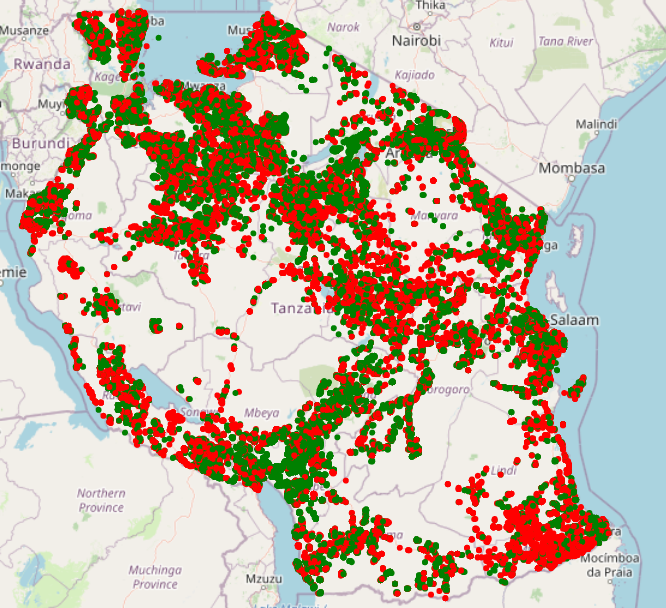

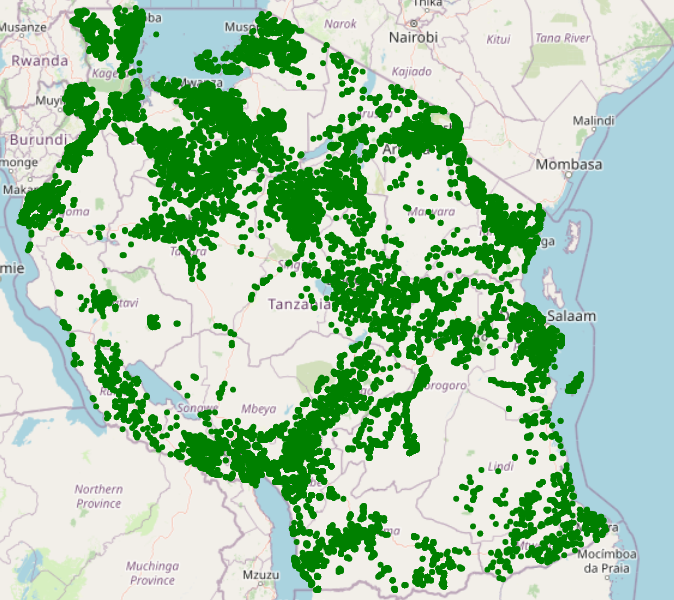

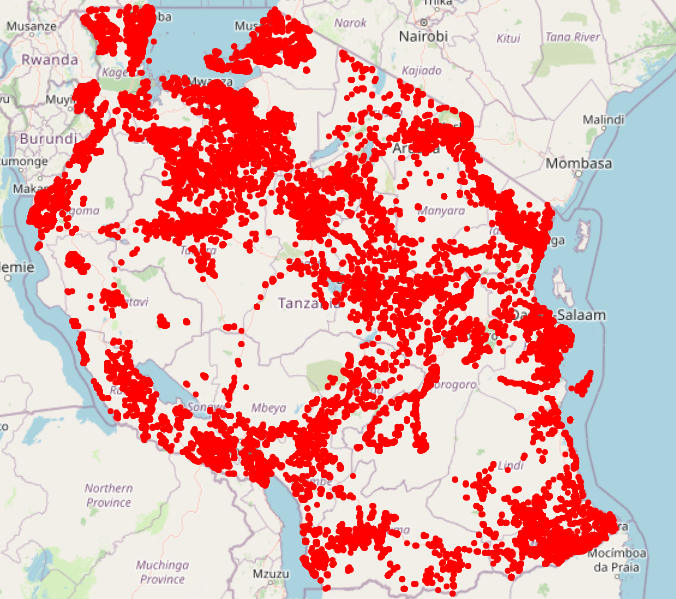

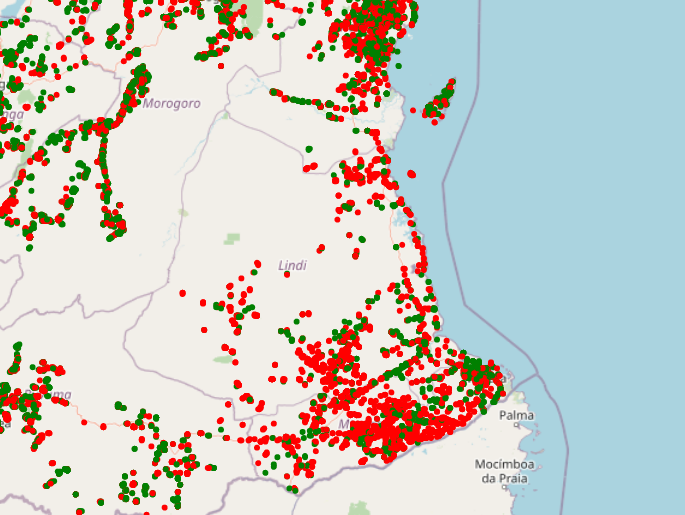